# Import's

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

# Function's

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Make a custom dateset

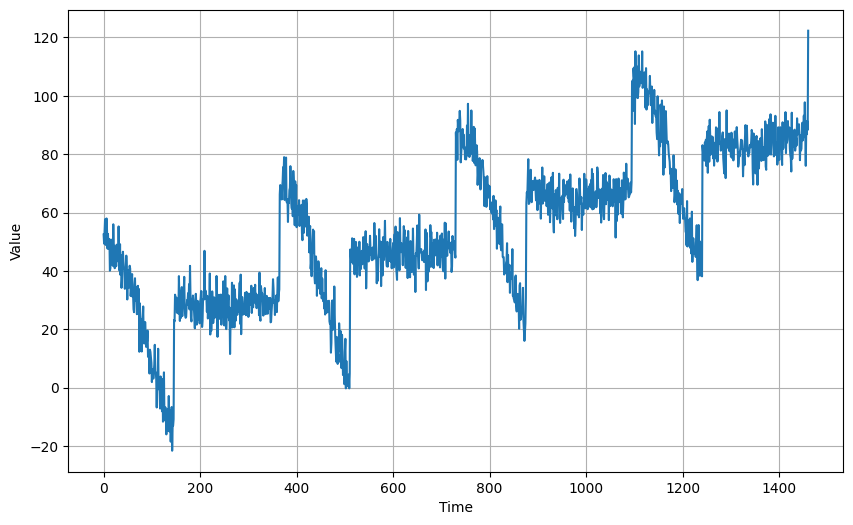

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Split Datsets

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# 1'D convulation layer and LSTM layer

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 15s 59ms/step - loss: 54.1385 - mae: 54.6384 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 53.6375 - mae: 54.1374 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 52.8335 - mae: 53.3333 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 51.8388 - mae: 52.3387 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 50.6856 - mae: 51.1855 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 49.3897 - mae: 49.8895 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 47.9456 - mae: 48.4454 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 46.3441 - mae: 46.8439 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 44.5783 - mae: 45.0780 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

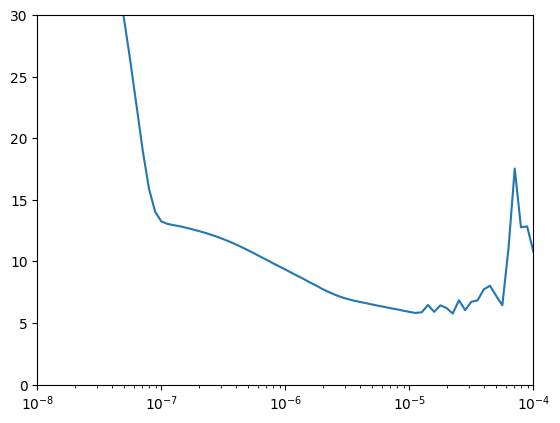

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 140ms/step - loss: 15.1519 - mae: 15.6440 - val_loss: 21.9089 - val_mae: 22.4040
Epoch 2/500
1/8 [==>...........................] - ETA: 0s - loss: 10.9508 - mae: 11.4361

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 36ms/step - loss: 9.7122 - mae: 10.1979 - val_loss: 15.8367 - val_mae: 16.3276
Epoch 3/500
8/8 [==============================] - 0s 27ms/step - loss: 8.4570 - mae: 8.9412 - val_loss: 17.7739 - val_mae: 18.2692
Epoch 4/500
8/8 [==============================] - 0s 26ms/step - loss: 7.6514 - mae: 8.1339 - val_loss: 13.2480 - val_mae: 13.7382
Epoch 5/500
8/8 [==============================] - 0s 25ms/step - loss: 7.1270 - mae: 7.6095 - val_loss: 12.3570 - val_mae: 12.8466
Epoch 6/500
8/8 [==============================] - 0s 25ms/step - loss: 6.8644 - mae: 7.3470 - val_loss: 10.2973 - val_mae: 10.7823
Epoch 7/500
8/8 [==============================] - 0s 32ms/step - loss: 6.7327 - mae: 7.2142 - val_loss: 11.0046 - val_mae: 11.4939
Epoch 8/500
8/8 [==============================] - 0s 38ms/step - loss: 6.4436 - mae: 6.9250 - val_loss: 10.1890 - val_mae: 10.6768
Epoch 9/500
8/8 [==============================] - 1s 43ms/step - loss: 6.3471 - mae: 6

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 3s 13ms/step


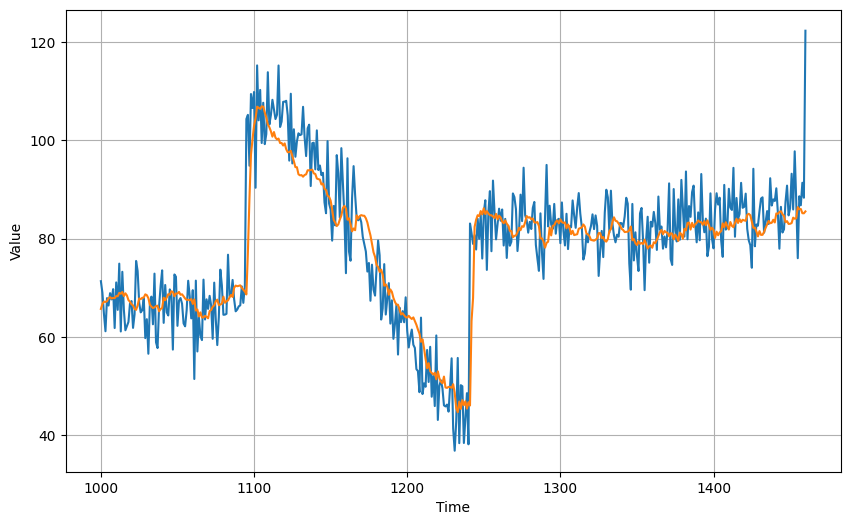

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.010619

# Fully Convolutional Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 58ms/step - loss: 42.0387 - mae: 42.5377 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 41.6270 - mae: 42.1261 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 41.1596 - mae: 41.6587 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 40.5926 - mae: 41.0917 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 39.9228 - mae: 40.4217 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 39.0638 - mae: 39.5624 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 37.8247 - mae: 38.3231 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 36.0478 - mae: 36.5466 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 33.3210 - mae: 33.8192 - lr: 1.8478e-

(0.0001, 0.1, 0.0, 30.0)

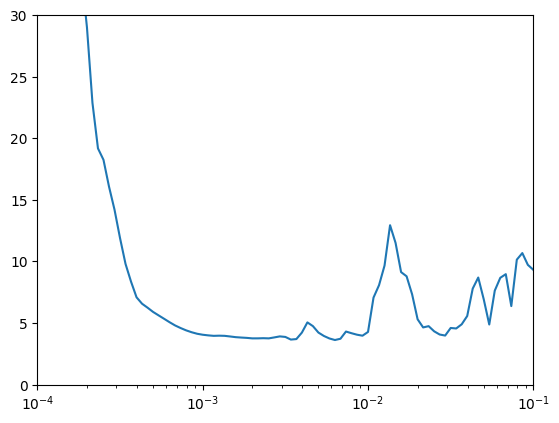

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 122ms/step - loss: 41.8287 - mae: 42.3277 - val_loss: 77.0016 - val_mae: 77.5016
Epoch 2/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 27ms/step - loss: 40.8604 - mae: 41.3596 - val_loss: 74.8923 - val_mae: 75.3923
Epoch 3/500
8/8 [==============================] - 0s 35ms/step - loss: 39.5185 - mae: 40.0173 - val_loss: 71.6680 - val_mae: 72.1680
Epoch 4/500
8/8 [==============================] - 0s 27ms/step - loss: 37.4877 - mae: 37.9864 - val_loss: 66.7888 - val_mae: 67.2888
Epoch 5/500
8/8 [==============================] - 0s 37ms/step - loss: 34.3482 - mae: 34.8468 - val_loss: 59.0194 - val_mae: 59.5194
Epoch 6/500
8/8 [==============================] - 0s 38ms/step - loss: 29.3955 - mae: 29.8937 - val_loss: 46.1859 - val_mae: 46.6856
Epoch 7/500
8/8 [==============================] - 0s 29ms/step - loss: 21.9142 - mae: 22.4101 - val_loss: 29.7543 - val_mae: 30.2500
Epoch 8/500
8/8 [==============================] - 0s 27ms/step - loss: 17.5728 - mae: 18.0671 - val_loss: 28.8852 - val_mae: 29.3829
Epoch 9/500
8/8 [==============================] - 0s 29ms/step - loss: 16

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 2s 19ms/step


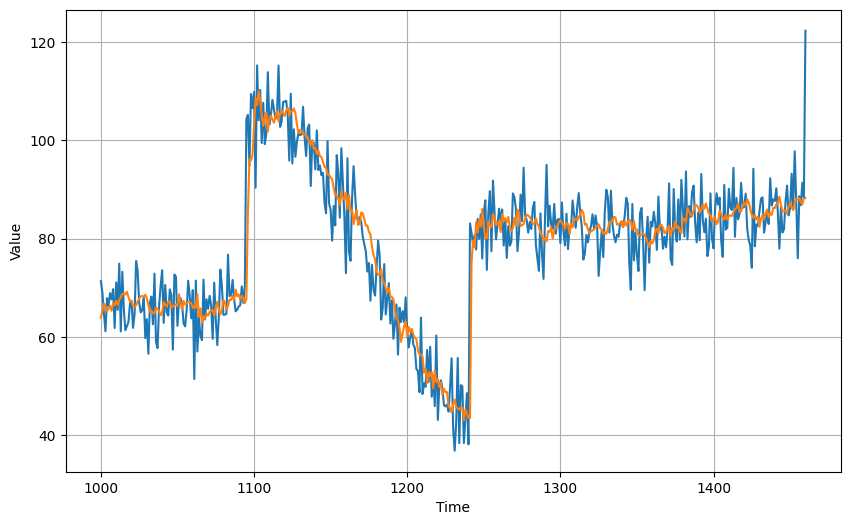

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.556661